# DCGAN on MNIST Dataset

This notebook demonstrates training a Deep Convolutional GAN (DCGAN) on the MNIST dataset. The notebook is divided into three main sections:

1. **Training the Original DCGAN**: Train a DCGAN on the MNIST dataset and document the loss curves and minimum errors.
2. **Enhancing the DCGAN**: Modify the model to improve its performance and document the updated loss curves and minimum errors.
3. **Comparison**: Collate a sample of generated images from both iterations and note the differences or similarities.

## Training the Original DCGAN

In this section, we train the original DCGAN on the MNIST dataset and document the loss curves and minimum errors observed.


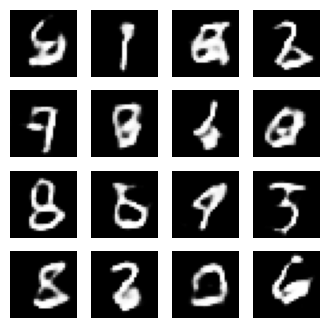

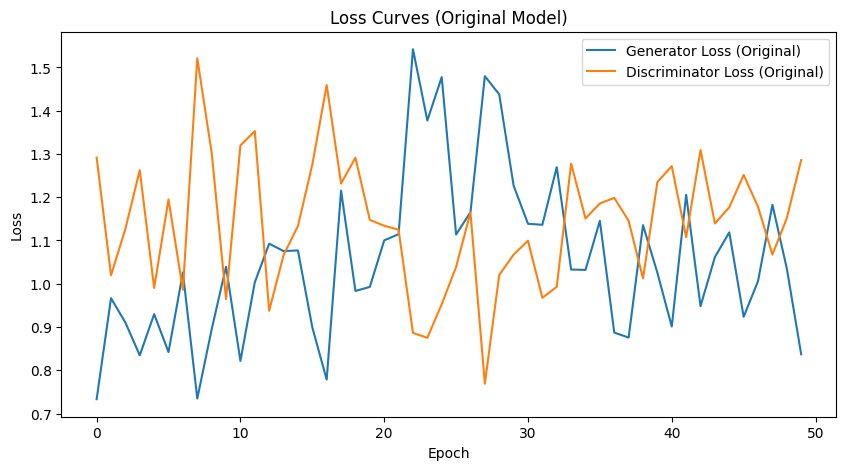

Minimum generator loss (Original): 0.7330774068832397
Minimum discriminator loss (Original): 0.7690075635910034


In [6]:
# Import necessary libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from tensorflow.keras import layers
from IPython import display

# Load and preprocess the dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Original Generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator_original = make_generator_model()

# Original Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator_original = make_discriminator_model()

# Loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints_mnist'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_original,
                                 discriminator=discriminator_original)

# Training functions
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# @tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_original(noise, training=True)

        real_output = discriminator_original(images, training=True)
        fake_output = discriminator_original(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator_original.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_original.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_original.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_original.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    gen_losses = []
    disc_losses = []
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)

        display.clear_output(wait=True)
        generate_and_save_images(generator_original, epoch + 1, seed)

        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

    display.clear_output(wait=True)
    generate_and_save_images(generator_original, epochs, seed)

    return gen_losses, disc_losses

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}_mnist.png'.format(epoch))
    plt.show()

# Train the original model
gen_losses_original, disc_losses_original = train(train_dataset, EPOCHS)

# Plot the loss curves for the original model
plt.figure(figsize=(10, 5))
plt.plot(gen_losses_original, label='Generator Loss (Original)')
plt.plot(disc_losses_original, label='Discriminator Loss (Original)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves (Original Model)')
plt.show()

# Print minimum errors observed for the original model
print(f'Minimum generator loss (Original): {min(gen_losses_original)}')
print(f'Minimum discriminator loss (Original): {min(disc_losses_original)}')

# Restore the latest checkpoint and generate a final image
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Enhancing the DCGAN

In this section, we enhance the original DCGAN model by adding more layers to the generator and discriminator. We then retrain the model and document the updated loss curves and minimum errors observed.

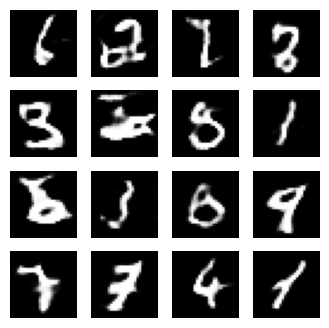

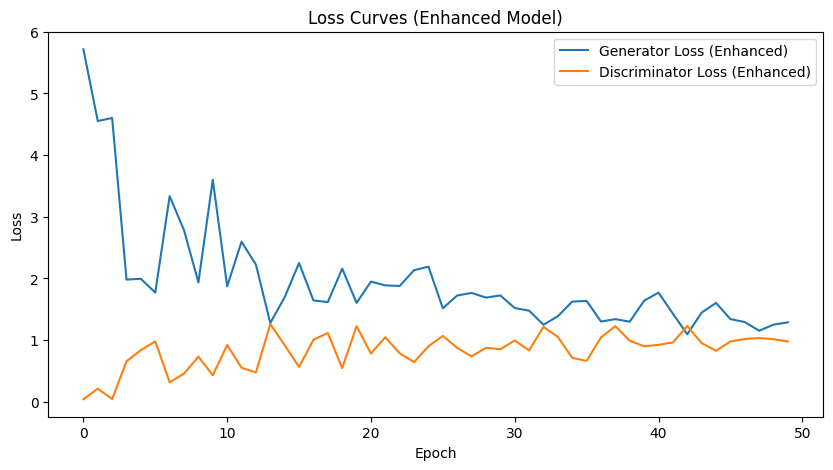

Minimum generator loss (Enhanced): 1.0955578088760376
Minimum discriminator loss (Enhanced): 0.04285833239555359


In [7]:
# Enhanced Generator model
def make_generator_model_enhanced():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 1024)))
    assert model.output_shape == (None, 7, 7, 1024)
    
    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator_enhanced = make_generator_model_enhanced()

# Enhanced Discriminator model
def make_discriminator_model_enhanced():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator_enhanced = make_discriminator_model_enhanced()

# Redefine loss and optimizers for the enhanced model
generator_optimizer_enhanced = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer_enhanced = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir_enhanced = './training_checkpoints_mnist_enhanced'
checkpoint_prefix_enhanced = os.path.join(checkpoint_dir_enhanced, "ckpt")
checkpoint_enhanced = tf.train.Checkpoint(generator_optimizer=generator_optimizer_enhanced,
                                 discriminator_optimizer=discriminator_optimizer_enhanced,
                                 generator=generator_enhanced,
                                 discriminator=discriminator_enhanced)

# Training functions for the enhanced model
# @tf.function
def train_step_enhanced(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_enhanced(noise, training=True)

        real_output = discriminator_enhanced(images, training=True)
        fake_output = discriminator_enhanced(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator_enhanced.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_enhanced.trainable_variables)

    generator_optimizer_enhanced.apply_gradients(zip(gradients_of_generator, generator_enhanced.trainable_variables))
    discriminator_optimizer_enhanced.apply_gradients(zip(gradients_of_discriminator, discriminator_enhanced.trainable_variables))

    return gen_loss, disc_loss

def train_enhanced(dataset, epochs):
    gen_losses = []
    disc_losses = []
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step_enhanced(image_batch)

        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)

        display.clear_output(wait=True)
        generate_and_save_images(generator_enhanced, epoch + 1, seed)

        if (epoch + 1) % 15 == 0:
            checkpoint_enhanced.save(file_prefix=checkpoint_prefix_enhanced)

        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

    display.clear_output(wait=True)
    generate_and_save_images(generator_enhanced, epochs, seed)

    return gen_losses, disc_losses

# Train the enhanced model
gen_losses_enhanced, disc_losses_enhanced = train_enhanced(train_dataset, EPOCHS)

# Plot the loss curves for both models
plt.figure(figsize=(10, 5))
# plt.plot(gen_losses_original, label='Generator Loss (Original)')
# plt.plot(disc_losses_original, label='Discriminator Loss (Original)')
plt.plot(gen_losses_enhanced, label='Generator Loss (Enhanced)')
plt.plot(disc_losses_enhanced, label='Discriminator Loss (Enhanced)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves (Enhanced Model)')
plt.show()

# Print minimum errors observed for the enhanced model
print(f'Minimum generator loss (Enhanced): {min(gen_losses_enhanced)}')
print(f'Minimum discriminator loss (Enhanced): {min(disc_losses_enhanced)}')

# Restore the latest checkpoint and generate a final image from the enhanced model
checkpoint_enhanced.restore(tf.train.latest_checkpoint(checkpoint_dir_enhanced))
# generate_and_save_images(generator_enhanced, EPOCHS, seed)

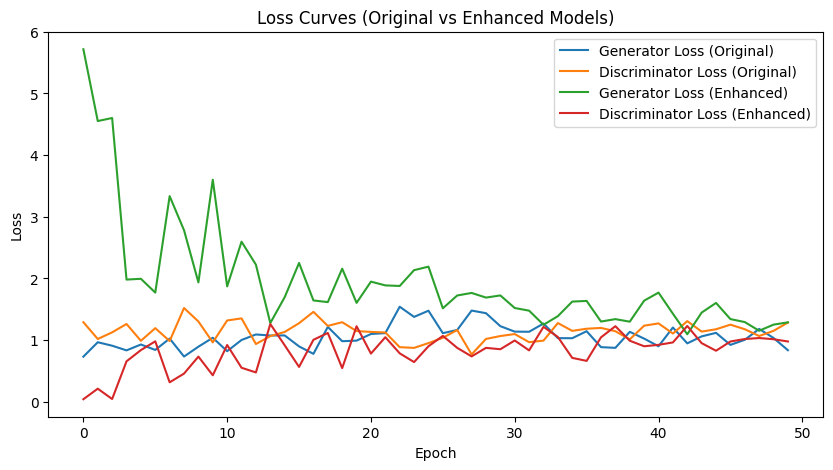

In [8]:
# Plot the loss curves for both models
plt.figure(figsize=(10, 5))
plt.plot(gen_losses_original, label='Generator Loss (Original)')
plt.plot(disc_losses_original, label='Discriminator Loss (Original)')
plt.plot(gen_losses_enhanced, label='Generator Loss (Enhanced)')
plt.plot(disc_losses_enhanced, label='Discriminator Loss (Enhanced)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves (Original vs Enhanced Models)')
plt.show()

Here we compare the images generated by both the original and enhanced DCGAN models. 

Minimum generator loss (Original): 0.7330774068832397  
Minimum discriminator loss (Original): 0.7690075635910034  
Minimum generator loss (Enhanced): 1.0955578088760376  
Minimum discriminator loss (Enhanced): 0.04285833239555359  
  
The generated images for both models are   
Original model vs Enhanced model 
  
  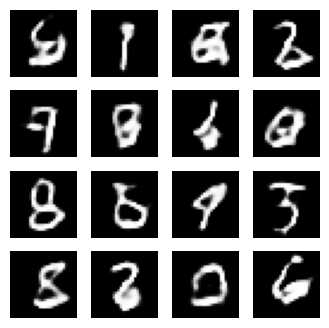  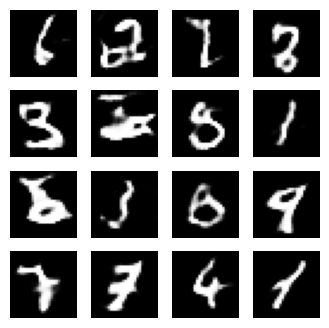

The enhanced model have somewhat clearer images of digits compared to the original model.  
The loss curves for original model  
  
  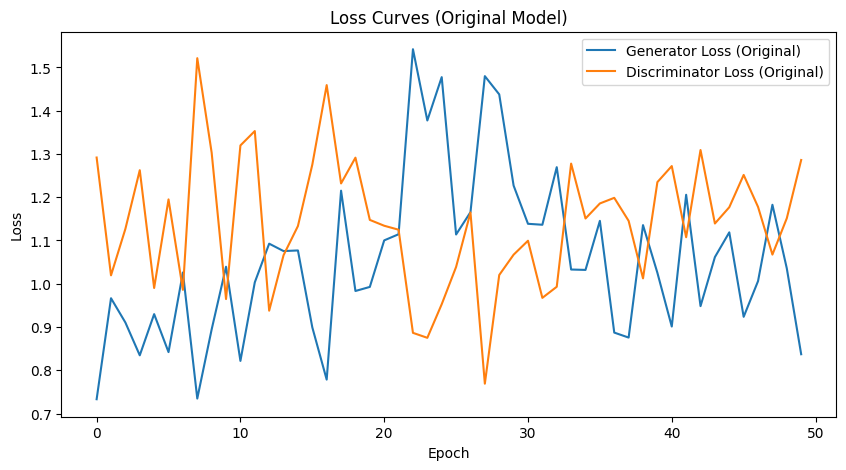  

The loss curves for enhanced model  
  
  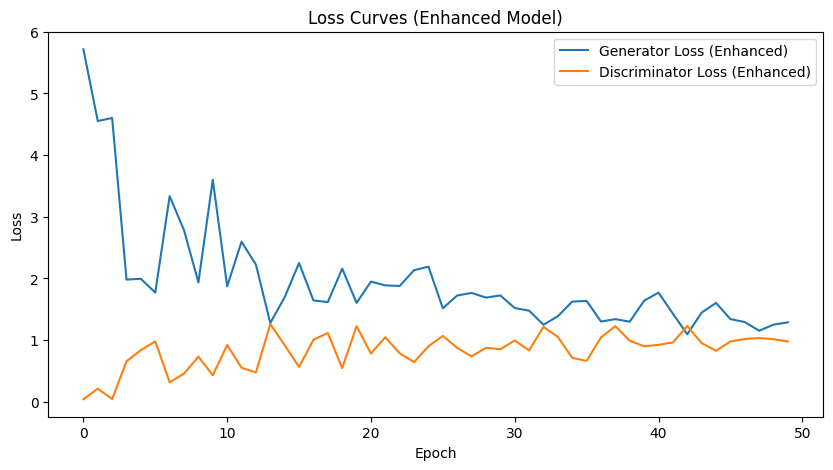
